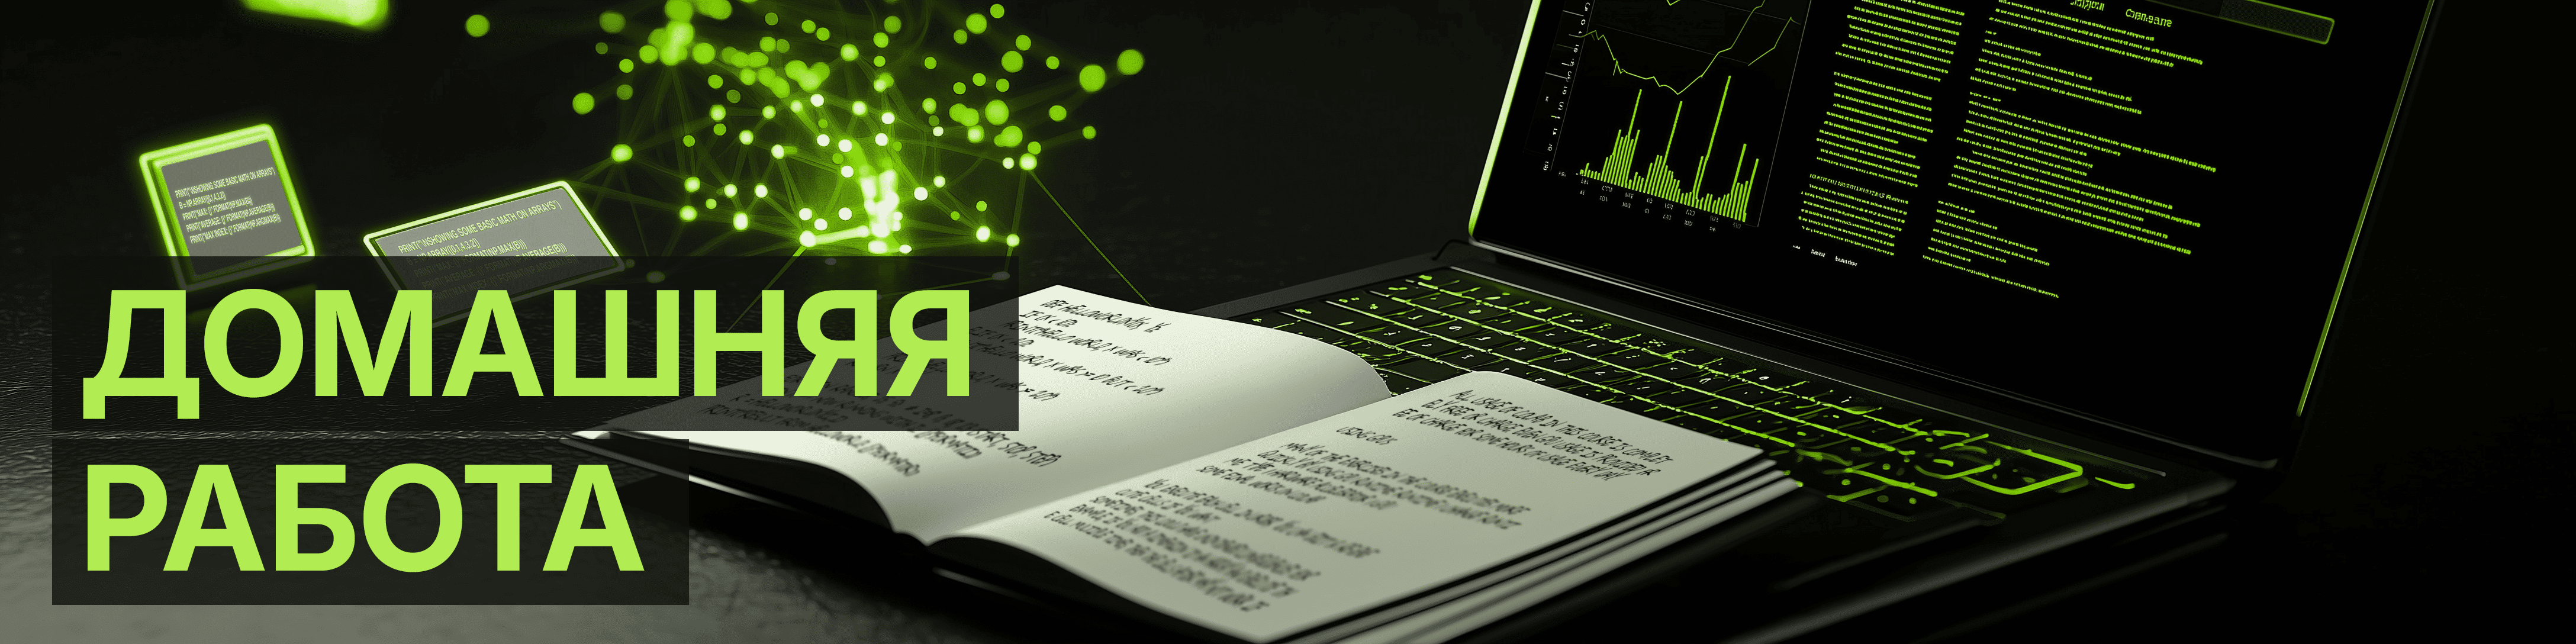

**Навигация по уроку**

1. [Keras v3. Современные подходы к CV (компьютерное зрение)](https://colab.research.google.com/drive/16ks3VjO38c7N4kXUsrdzUbunJOxRu3Fq)
2. [Перенос обучения в Keras 3.0](https://colab.research.google.com/drive/1x2qd4MvG3ODgNrE2uqxRAZB70dGgdGft)
3. [Знакомство с KerasCV](https://colab.research.google.com/drive/1ZWfrEDQaQqDmVUF0yk7N4yoMHRkXf9K-)
4. Домашняя работа

В домашней работе вам необходимо, используя пример из урока 19.2 и Keras 3, произвести тонкую настройку модели второй версии [EfficientNetV2](https://keras.io/api/applications/efficientnet_v2/) на примере набора данных [Stanford Dogs](https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip).

Баллы за задание начисляются следующим образом:
* 3 балла - дается за успешно выполненное задание с точностью на проверочной выборке не менее 75%, в задании должна быть проведена аугментация данных.
* Для получения 4-х баллов необходимо добиться, чтобы точности на проверочной и тестовой выборках были выше 75%.
* Для получения 5-ти баллов необходимо случайным образом отобрать 10 пород собак, выполнить аугментацию и добиться точности как на обучающей, так и проверочной выборках более 85%.  

In [ ]:
# Ваше решение

**Примечание**. В 2021 году появилась вторая версия модели EfficientNetV2 (https://arxiv.org/pdf/2104.00298.pdf), которая была добавлена в Keras.

#Библиотеки

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2M

IMAGE_SIZE = (480, 480) # Размер определен выбором модели
BATCH_SIZE = 128

# Обработаем фото

## Загрузка

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

!unzip -qo "stanford_dogs" -d ./dataset

IMAGE_PATH = './dataset/'

--2025-04-07 17:31:35--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  53.0MB/s    in 15s     

2025-04-07 17:31:50 (50.7 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



## Очистим от битых файлов

In [ ]:
num_skipped = 0
for folder_name in os.listdir(IMAGE_PATH):              #перебираем папки по именам
    folder_path = os.path.join(IMAGE_PATH, folder_name) #добавляем имена папок к пути
    for fname in os.listdir(folder_path):               #перебираем имена файлов из папок
        fpath = os.path.join(folder_path, fname)        #добавляем имена файлов к пути
        try:
            fobj = open(fpath, "rb")                    #открываем файл как бинарный
            is_jfif = b"JFIF" in fobj.peek(10)          #ищем наличие JFIF
        finally:
            fobj.close()                                #закрываем файл

        if not is_jfif:                                 #если нет метки
            num_skipped += 1
            os.remove(fpath)                            #удаляем файл

print(f"Удалено поврежденных файлов:{num_skipped}")

Удалено поврежденных файлов:10


## Сгенерируем датасет
Разделим сет на обучающу, проверочную и тестовую выборки в соотношении 80:10:10

In [ ]:
#создадим общий сет
full_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    image_size = IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

#разделяем сет на 3 части
dataset_size = len(full_ds) * BATCH_SIZE #примерный размер сета
train_size = int(0.8 * dataset_size)     #80% обучение
val_size = int(0.1 * dataset_size)       #10% валидация
test_size = dataset_size - train_size - val_size    #оставшееся в тестовую выборку

train_ds = full_ds.take(train_size // BATCH_SIZE)   #отбираем обучающие изображения
remain = full_ds.skip(train_size // BATCH_SIZE)     #остаток после отбора
val_ds = remain.take(val_size // BATCH_SIZE)        #отбираем валидацию
test_ds = remain.skip(val_size // BATCH_SIZE)       #остаток - тестовая выборка

print(f"Примерные разделения изображений\nTrain: {train_size}\nVal: {val_size}\nTest: {test_size}")

Found 20570 files belonging to 120 classes.
Примерные разделения изображений
Train: 16486
Val: 2060
Test: 2062


Определим метки

In [ ]:
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

CLASS_COUNT = len(CLASS_LIST)

print(f"Количество классов: {CLASS_COUNT}")
print(f"Метки классов: {CLASS_LIST}")

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

Посмотрим в датасеты на первые 16 картинок

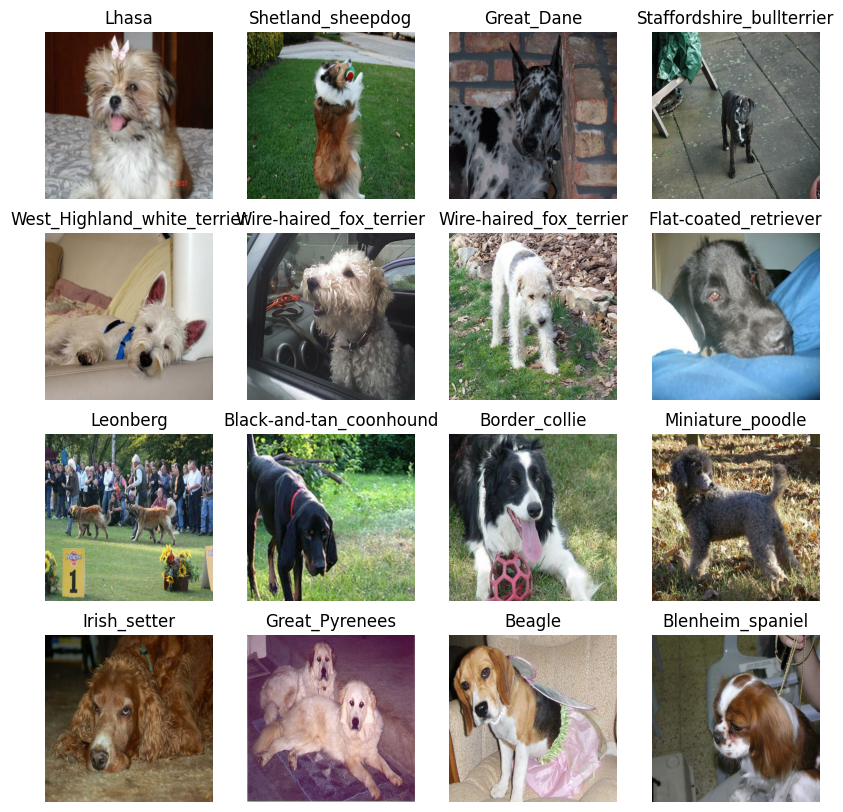

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):  # 1 батч тестового набора
    for i in range (16):                # 16 картинок
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]])# метка картинки
        plt.axis("off")

# Аугментируем наборы

На каждый класс у нас всего по 170 изображений, что очень мало для обучения, необходимо расширить набор путем аугментации имеющихся картинок

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),  # поворот
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # сдвиг
    layers.RandomFlip(),                # отражение
    layers.RandomContrast(factor=0.1),   # контраст
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

Посмотрим на работу функции аугментации

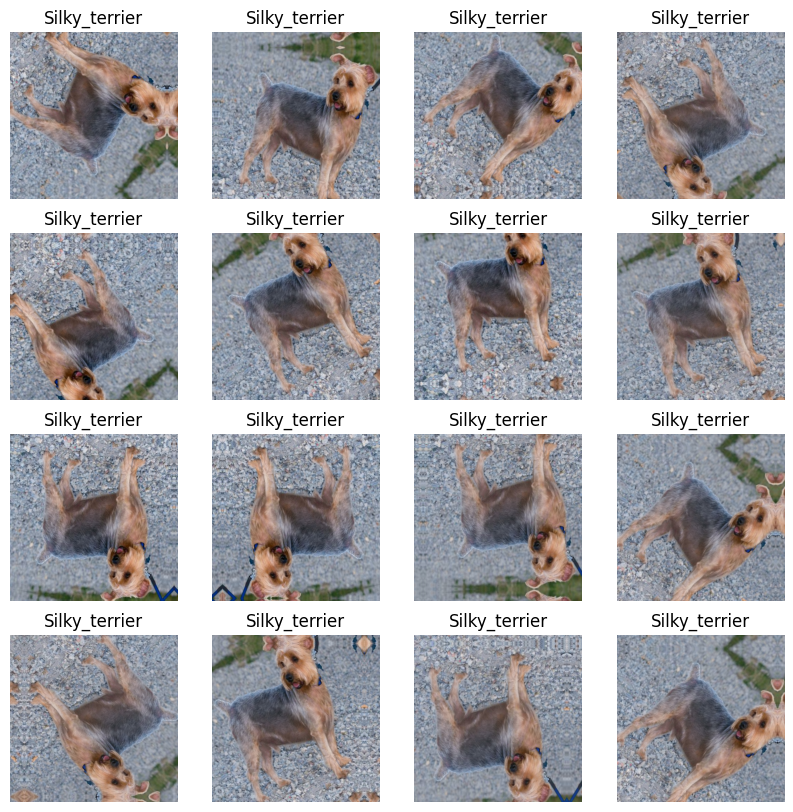

In [ ]:
plt.figure(figsize=(10, 10))
for images, label in val_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8"))
        plt.title("{}".format(CLASS_LIST[label[0]]))
        plt.axis("off")

Применим функцию аугментации к наборам, а так же закодируем классы в One-hot

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

val_ds = val_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

test_ds = test_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# предварительная выборка в память
# помогает ускорить обработку
train_ds=train_ds.prefetch(tf_data.AUTOTUNE)
val_ds=val_ds.prefetch(tf_data.AUTOTUNE)
test_ds=test_ds.prefetch(tf_data.AUTOTUNE)

# Вспомогательные функции

In [ ]:
import numpy as np
def show_plot(history, class_count=CLASS_COUNT):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

# Перенос обучения

Загружаем модель EfficientNetV2M с весами и дообучаем ее на нашем наборе

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2M(include_top=False, input_tensor=inputs, weights="imagenet")

    # замораживаем обученную модель
    model.trainable = False

    # добавляем наши верхние слои
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name = "pred")(x)

    # компилируем
    model = keras.Model(inputs, outputs, name = "EfficientNetV2M")
    optimizer = keras.optimizers.Adam(learning_rate = 1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

## Обучаем модель

In [ ]:
epochs = 10

callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_pretrain_M.keras',
                                            monitor='val_acc',
                                             save_best_only=True,
                                             mode="max",
                                             verbose=0)
]

model = build_model(num_classes=CLASS_COUNT)

In [ ]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 601s 4s/step - acc: 0.6887 - loss: 2.0939 - val_acc: 0.7935 - val_loss: 0.8090
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - acc: 0.8086 - loss: 1.0027 - val_acc: 0.8364 - val_loss: 0.5945
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - acc: 0.8344 - loss: 0.6254 - val_acc: 0.8506 - val_loss: 0.5087
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - acc: 0.8486 - loss: 0.5242 - val_acc: 0.8452 - val_loss: 0.5260
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - acc: 0.8527 - loss: 0.4830 - val_acc: 0.8604 - val_loss: 0.4757
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - acc: 0.8609 - loss: 0.4530 - val_acc: 0.8545 - val_loss: 0.4962
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - acc: 0.8675 - loss: 0.4407 - val_acc: 0.8486 - val_loss: 0.5054
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - acc: 0.8645 - loss: 0.4294 - val_acc: 0.8638 - val_loss: 0.4661
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/

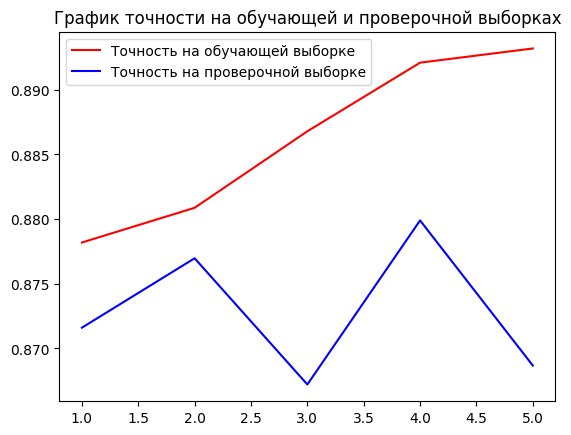

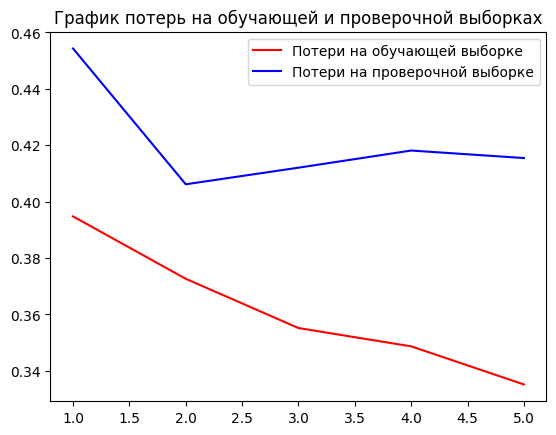

In [ ]:
show_plot(history)

In [ ]:
!wget https://storage.yandexcloud.net/quiz.pic/best_model_pretrain_M.keras

from tensorflow.keras.models import load_model

model = load_model('best_model_pretrain_M.keras')

--2025-04-07 16:00:31--  https://storage.yandexcloud.net/quiz.pic/best_model_pretrain_M.keras
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216980093 (207M) [application/x-www-form-urlencoded]
Saving to: ‘best_model_pretrain_M.keras’

best_model_pretrain 100%[===================>] 206.93M  20.4MB/s    in 11s     

2025-04-07 16:00:43 (18.7 MB/s) - ‘best_model_pretrain_M.keras’ saved [216980093/216980093]



In [ ]:
# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(test_ds, batch_size=BATCH_SIZE)

# Вывод результатов
print(f"\nРезультаты на тестовой выборке:")
print(f"• Потери: {test_loss*100:.2f}%")
print(f"• Точность: {test_accuracy*100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.9401 - loss: 0.1966

Результаты на тестовой выборке:
• Потери: 18.83%
• Точность: 94.20%


Точность нашей модели с использованием EfficientNetV2M достигла 86% на валидации и 94% на тестовой выборке. Отличный результат! Для сравнения я сначала использовал модель EfficientNetV2B0, но ее точность не превышала 69% на валидации при различных настройках, включая тонкую.

## Продолжаем обучение

Посмотрим, как выглядят последние слои нашей модели и разморозим несколько для точной настройки

In [ ]:
len(model.layers)

744

In [ ]:
for i, layer in enumerate(model.layers):
    if i > 700:
        print(f"Layer {i}: {layer.name} -> trainable={layer.trainable}")

Layer 701: block7c_se_expand -> trainable=False
Layer 702: block7c_se_excite -> trainable=False
Layer 703: block7c_project_conv -> trainable=False
Layer 704: block7c_project_bn -> trainable=False
Layer 705: block7c_drop -> trainable=False
Layer 706: block7c_add -> trainable=False
Layer 707: block7d_expand_conv -> trainable=False
Layer 708: block7d_expand_bn -> trainable=False
Layer 709: block7d_expand_activation -> trainable=False
Layer 710: block7d_dwconv2 -> trainable=False
Layer 711: block7d_bn -> trainable=False
Layer 712: block7d_activation -> trainable=False
Layer 713: block7d_se_squeeze -> trainable=False
Layer 714: block7d_se_reshape -> trainable=False
Layer 715: block7d_se_reduce -> trainable=False
Layer 716: block7d_se_expand -> trainable=False
Layer 717: block7d_se_excite -> trainable=False
Layer 718: block7d_project_conv -> trainable=False
Layer 719: block7d_project_bn -> trainable=False
Layer 720: block7d_drop -> trainable=False
Layer 721: block7d_add -> trainable=False
La

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 22 верхних слоя за исключением BatchNormalization
    for layer in model.layers[-22:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

In [ ]:
epochs = 5

callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_pretrain_fine_tuning.keras',
                                            monitor='val_acc',
                                             save_best_only=True,
                                             mode="max",
                                             verbose=0)
]

In [ ]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - acc: 0.8703 - loss: 0.4233 - val_acc: 0.8716 - val_loss: 0.4543
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 508s 4s/step - acc: 0.8800 - loss: 0.3799 - val_acc: 0.8770 - val_loss: 0.4061
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - acc: 0.8881 - loss: 0.3508 - val_acc: 0.8672 - val_loss: 0.4120
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 509s 4s/step - acc: 0.8898 - loss: 0.3606 - val_acc: 0.8799 - val_loss: 0.4181
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step - acc: 0.8931 - loss: 0.3377 - val_acc: 0.8687 - val_loss: 0.4154


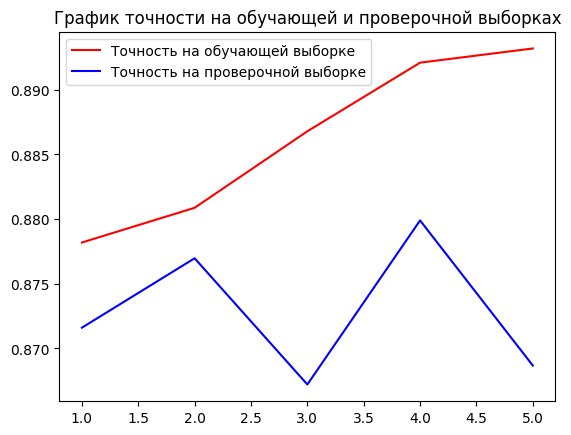

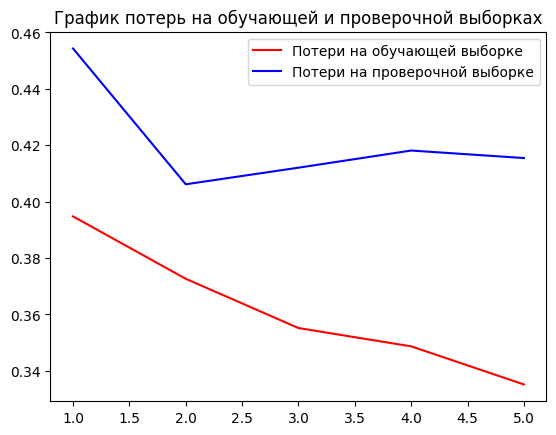

In [ ]:
show_plot(history)

In [ ]:
# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(test_ds, batch_size=BATCH_SIZE)

# Вывод результатов
print(f"\nРезультаты на тестовой выборке:")
print(f"• Потери: {test_loss*100:.2f}%")
print(f"• Точность: {test_accuracy*100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - acc: 0.9485 - loss: 0.1608

Результаты на тестовой выборке:
• Потери: 16.79%
• Точность: 94.71%


# Результат
После тонкой настройки точность модели на тестовых данных немного поднялась - на 0,5%, а на валидации на 0,87%

# Отберем 10 пород для обучения

In [ ]:
import os
import shutil
import random

#все породы
all_dogs = os.listdir(IMAGE_PATH)
#отбираем 10
random.seed(42)
selected_dogs = random.sample(all_dogs, 10)

new_set_dir = './small_set/'
os.makedirs(new_set_dir, exist_ok=True)

for dog in selected_dogs:
    dog_dir = os.path.join(IMAGE_PATH, dog)
    new_dog_dir = os.path.join(new_set_dir, dog)
    os.makedirs(new_dog_dir, exist_ok=True)

    for img in os.listdir(dog_dir):
        src_path = os.path.join(dog_dir, img)
        dst_path = os.path.join(new_dog_dir, img)
        shutil.copy(src_path, dst_path)

## Разделим сет на выборки

In [ ]:
BATCH_SIZE = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    new_set_dir, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 1762 files belonging to 10 classes.
Using 1410 files for training.
Using 352 files for validation.


In [ ]:
CLASS_LIST = sorted(os.listdir(new_set_dir))

CLASS_COUNT = len(CLASS_LIST)

print(f"Количество классов: {CLASS_COUNT}")
print(f"Метки классов: {CLASS_LIST}")

Количество классов: 10
Метки классов: ['Afghan_hound', 'Boston_bull', 'German_shepherd', 'Giant_schnauzer', 'Golden_retriever', 'Miniature_schnauzer', 'Pomeranian', 'Saluki', 'Staffordshire_bullterrier', 'Vizsla']


# Аугментируем наборы

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),  # поворот
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # сдвиг
    layers.RandomFlip(),                # отражение
    layers.RandomContrast(factor=0.1),   # контраст
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

val_ds = val_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# предварительная выборка в память
# помогает ускорить обработку
train_ds=train_ds.prefetch(tf_data.AUTOTUNE)
val_ds=val_ds.prefetch(tf_data.AUTOTUNE)

# Перенос обучения

Загружаем модель EfficientNetV2S с весами и дообучаем ее на нашем наборе

In [ ]:
from keras.applications import EfficientNetV2S
def build_model_S(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2S(include_top=False, input_tensor=inputs, weights="imagenet")

    # замораживаем обученную модель
    model.trainable = False

    # добавляем наши верхние слои
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name = "pred")(x)

    # компилируем
    model = keras.Model(inputs, outputs, name = "EfficientNetV2M")
    optimizer = keras.optimizers.Adam(learning_rate = 1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
epochs = 10

callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_pretrain_S.keras',
                                            monitor='val_acc',
                                             save_best_only=True,
                                             mode="max",
                                             verbose=0)
]

model = build_model_S(num_classes=CLASS_COUNT)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
history_S = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - acc: 0.8415 - loss: 0.6974 - val_acc: 0.9403 - val_loss: 0.1750
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 999ms/step - acc: 0.9450 - loss: 0.4221 - val_acc: 0.9545 - val_loss: 0.1802
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 974ms/step - acc: 0.9642 - loss: 0.2374 - val_acc: 0.9233 - val_loss: 0.3115
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 961ms/step - acc: 0.9567 - loss: 0.2618 - val_acc: 0.9489 - val_loss: 0.2990
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 952ms/step - acc: 0.9511 - loss: 0.3849 - val_acc: 0.9375 - val_loss: 0.4141
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 988ms/step - acc: 0.9500 - loss: 0.3237 - val_acc: 0.9574 - val_loss: 0.3823
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 949ms/step - acc: 0.9704 - loss: 0.1759 - val_acc: 0.9545 - val_loss: 0.5081
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 957ms/step - acc: 0.9765 - loss: 0.1624 - val_acc: 0.9460 - val_loss: 0.4551
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 960ms/st

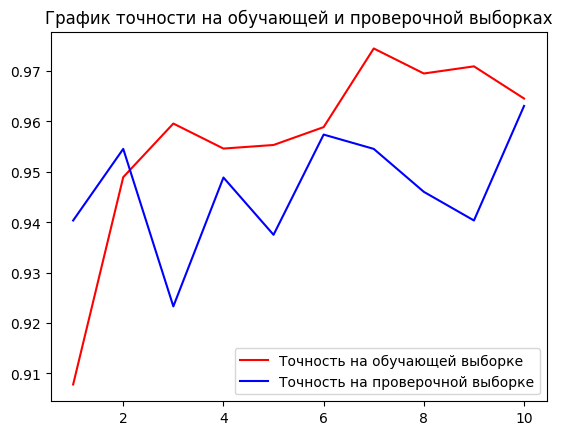

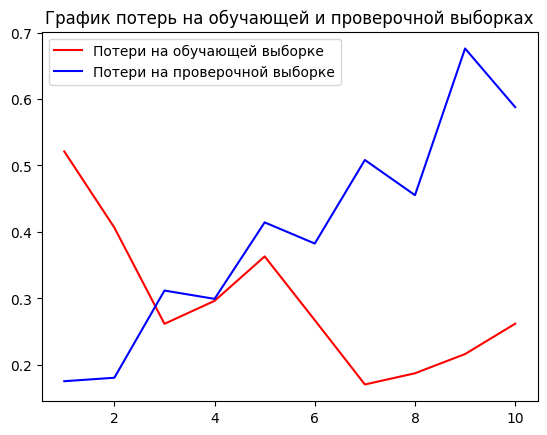

In [ ]:
show_plot(history_S)

## Результат

Модель с EfficientNetV2S показала точность на валидации в районе 95% уже с первой эпохи. Дальнейшее ее обучение приводит к переобучению, в целом обучение можно было останавливать уже на 2 эпохе, которая показывает небольшое увеличение потерь на валидации и небольшое увеличение точности на тех же данных. Дальнейшее обучение приводит к подстройке модели и потере обобщающей ценности.